In [1]:
import sys
sys.path.append('../')
import pandas as pd
import backtrader as bt
from datetime import datetime
import matplotlib.pyplot as plt
from Tools.backtest_tools import *
import plotly.graph_objects as go
import numpy as np

In [2]:
# Load the data and convert the timestamp to datetime
df_s = pd.read_csv('../DB/5m/INJUSDT_5m.csv', parse_dates=True) 

# df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
# # # Convert 'date' to datetime format
df_s['datetime'] = pd.to_datetime(df_s['datetime'])  # Assuming the 'date' is in milliseconds

# # # Set 'date' as index
df_s.set_index('datetime', inplace=True)

# df_s.iloc[0]
# df_s.dtypes
# df_s.head()
df = df_s.copy()

In [3]:
df

,open,high,low,close,volume,quote_volume
datetime,,,,,,
2022-11-21 03:15:00,1.564,1.564,1.559,1.559,0,0
2022-11-21 03:20:00,1.559,1.560,1.556,1.557,0,0
2022-11-21 03:25:00,1.557,1.564,1.553,1.563,0,0
2022-11-21 03:30:00,1.563,1.576,1.563,1.576,0,0
2022-11-21 03:35:00,1.576,1.577,1.575,1.577,0,0
...,...,...,...,...,...,...
2024-09-04 04:05:00,15.645,15.651,15.603,15.608,0,0
2024-09-04 04:10:00,15.608,15.630,15.600,15.627,0,0
2024-09-04 04:15:00,15.627,15.631,15.572,15.576,0,0


In [4]:
for n in [100, 200]:
    df[f'MA{n}'] = df['close'].rolling(window=n).mean()


# Calculate Bollinger Bands
df['BB_Middle'] = df['close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['close'].rolling(window=20).std()

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df)

def calculate_atr(data, window=14):
    high_low = data['high'] - data['low']
    high_close = (data['high'] - data['close'].shift()).abs()
    low_close = (data['low'] - data['close'].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=window).mean()

df['ATR'] = calculate_atr(df)

# Calculate Percentage Change
df['Price_Change_1'] = df['close'].pct_change(periods=1)
df['Price_Change_3'] = df['close'].pct_change(periods=3)
df['Price_Change_5'] = df['close'].pct_change(periods=5)

# Add Time-Based Features
df['Hour'] = df.index.hour
df['Day_of_Week'] = df.index.dayofweek

# # Calculate Volume Change
# df['Volume_Change'] = df['volume'].pct_change()

# Calculate Open-Close and High-Low Differences
df['Open_Close_Diff'] = df['close'] - df['open']
df['High_Low_Diff'] = df['high'] - df['low']

# Drop NaN values that were created during calculations
df.dropna(inplace=True)

In [5]:
df.dropna(inplace=True)

In [6]:
# Define the percentage change for labeling
percentage_threshold = 0.03  # One percent

# Create the target variable
df['Target'] = np.where(df['close'].shift(-3) >= df['close'] * (1 + percentage_threshold), 1, 
                        np.where(df['close'].shift(-3) <= df['close'] * (1 - percentage_threshold), 0, np.nan))

# Drop rows with NaN in the Target column
df.dropna(subset=['Target'], inplace=True)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Define features and target
X = df.drop(columns=['Target'])  # Features
y = df['Target']                  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.60      0.39      0.47        88
         1.0       0.63      0.80      0.70       114

    accuracy                           0.62       202
   macro avg       0.61      0.59      0.59       202
weighted avg       0.61      0.62      0.60       202

[[34 54]
 [23 91]]


In [8]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)



Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [9]:
# Initialize the model with the best parameters
best_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

# Train the model
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.52      0.42      0.47        88
         1.0       0.61      0.70      0.65       114

    accuracy                           0.58       202
   macro avg       0.57      0.56      0.56       202
weighted avg       0.57      0.58      0.57       202

[[37 51]
 [34 80]]


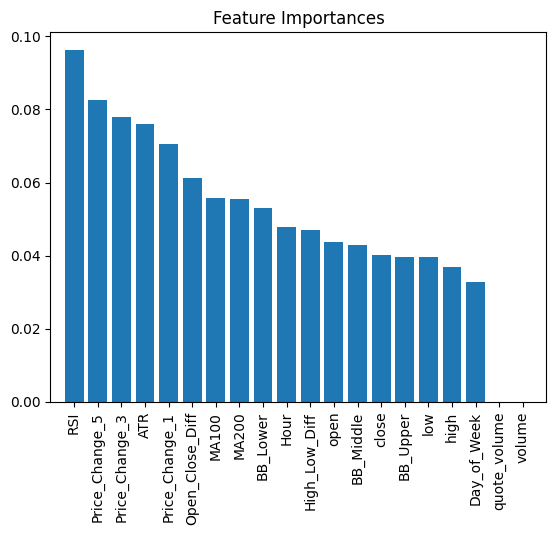

In [10]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


In [11]:
importances = best_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Set a threshold for significance (you can adjust this value)
threshold = 0.01  # Keep features with importance greater than this threshold

# Filter features based on the threshold
significant_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Keep only significant columns in the original DataFrame
X_significant = X[significant_features]

In [12]:
from sklearn.feature_selection import RFE

# Initialize the RFE model with the Random Forest classifier
rfe = RFE(estimator=best_model, n_features_to_select=5)  # Choose the number of features you want to keep
rfe.fit(X_train_scaled, y_train)

# Get the selected feature mask
selected_features = rfe.support_

# Filter the DataFrame to keep only significant columns
X_significant = X.loc[:, selected_features]


In [13]:
# Update your DataFrame for further processing
X_train_significant, X_test_significant = train_test_split(X_significant, test_size=0.3, random_state=42, shuffle=False)

# Standardize the selected features
X_train_significant_scaled = scaler.fit_transform(X_train_significant)
X_test_significant_scaled = scaler.transform(X_test_significant)

# Now you can train your model using the significant features
best_model.fit(X_train_significant_scaled, y_train)
y_pred_significant = best_model.predict(X_test_significant_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred_significant))
print(confusion_matrix(y_test, y_pred_significant))


              precision    recall  f1-score   support

         0.0       0.56      0.51      0.53        88
         1.0       0.64      0.68      0.66       114

    accuracy                           0.61       202
   macro avg       0.60      0.60      0.60       202
weighted avg       0.61      0.61      0.61       202

[[45 43]
 [36 78]]
